<a href="https://colab.research.google.com/github/ogunsolahabib/Learning-git/blob/master/Time_Series_001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load the dataset
# Assuming your file is named 'Btc_Eth_Data.csv' and is in the same directory
try:
    df = pd.read_csv('Btc_Eth_Data.csv', parse_dates=['Date'], index_col='Date')
except FileNotFoundError:
    print("Error: 'Btc_Eth_Data.csv' not found. Please check the file path.")
    # Exit or handle the error appropriately
    exit()


# Select the Bitcoin closing price
btc_price = df[['Close_Btc']].copy() # Use [['...']] to keep it as a DataFrame

# Check for missing values
print("Missing values before handling:")
print(btc_price.isnull().sum())

# Handle missing values (e.g., forward fill, interpolation, or dropping)
# Forward fill is common in time series
btc_price.fillna(method='ffill', inplace=True)
# Or interpolate: btc_price.interpolate(method='time', inplace=True)

print("\nMissing values after handling:")
print(btc_price.isnull().sum())

# Display the first few rows and info
print("\nData Head:")
print(btc_price.head())
print("\nData Info:")
btc_price.info()

Missing values before handling:
Close_Btc    0
dtype: int64

Missing values after handling:
Close_Btc    0
dtype: int64

Data Head:
              Close_Btc
Date                   
2020-08-07  11601.47266
2020-08-08  11754.04590
2020-08-09  11675.73926
2020-08-10  11878.11133
2020-08-11  11410.52539

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2020-08-07 to 2022-08-07
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Close_Btc  731 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


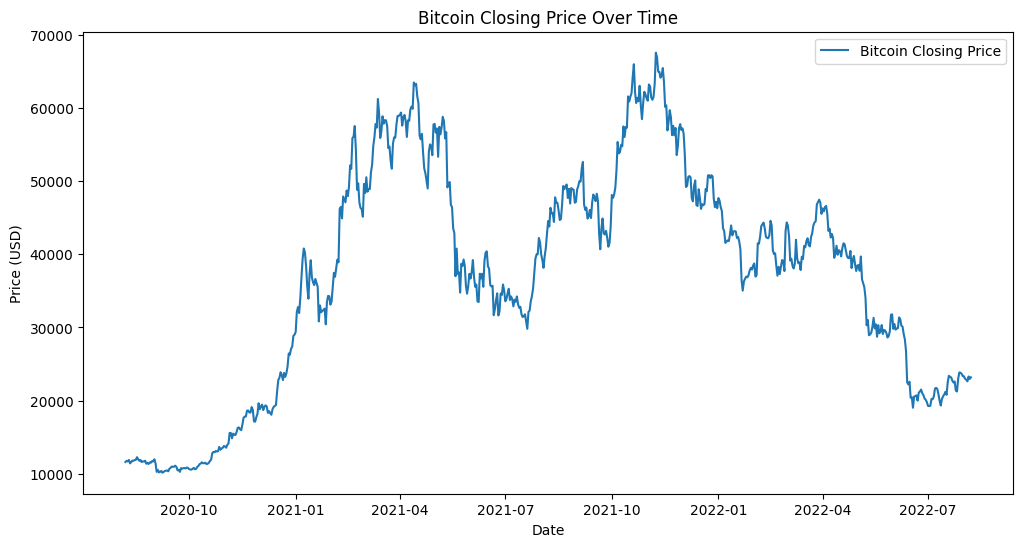

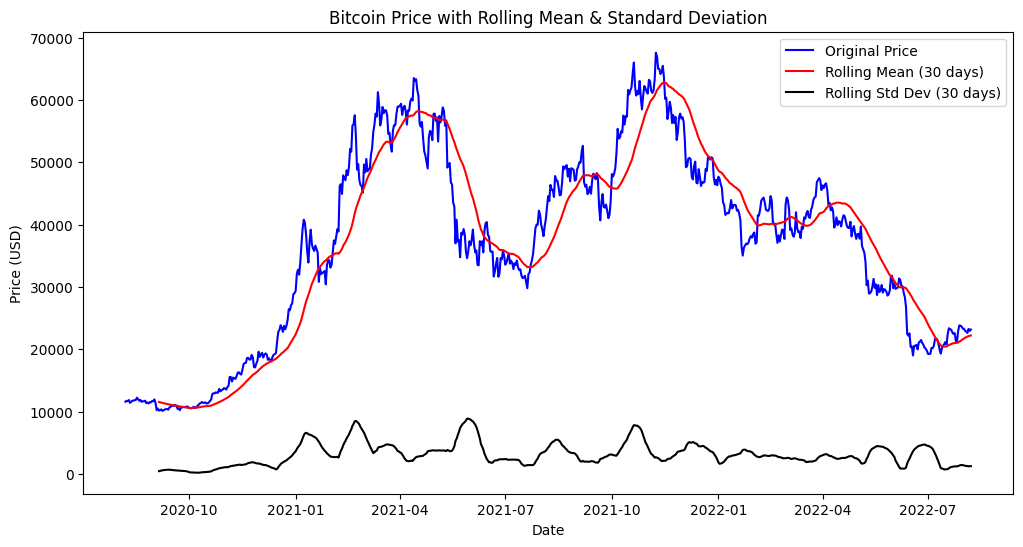

In [4]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(btc_price['Close_Btc'], label='Bitcoin Closing Price')
plt.title('Bitcoin Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)') # Assuming USD, adjust if needed
plt.legend()
plt.show()

# Optional: Plot rolling statistics to visually check for stationarity
rolling_mean = btc_price['Close_Btc'].rolling(window=30).mean() # 30-day rolling mean
rolling_std = btc_price['Close_Btc'].rolling(window=30).std()   # 30-day rolling std dev

plt.figure(figsize=(12, 6))
plt.plot(btc_price['Close_Btc'], color='blue', label='Original Price')
plt.plot(rolling_mean, color='red', label='Rolling Mean (30 days)')
plt.plot(rolling_std, color='black', label='Rolling Std Dev (30 days)')
plt.title('Bitcoin Price with Rolling Mean & Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


--- Augmented Dickey-Fuller Test Results for Original Bitcoin Price ---
ADF Statistic: -1.7121
p-value: 0.4249
Critical Values:
  1%: -3.4393
  5%: -2.8655
  10%: -2.5689
Conclusion: Fail to reject the null hypothesis. Original Bitcoin Price is likely non-stationary (p-value > 0.05).

Original series is non-stationary. Applying first-order differencing.

--- Augmented Dickey-Fuller Test Results for First-Differenced Bitcoin Price ---
ADF Statistic: -27.7820
p-value: 0.0000
Critical Values:
  1%: -3.4394
  5%: -2.8655
  10%: -2.5689
Conclusion: Reject the null hypothesis. First-Differenced Bitcoin Price is likely stationary (p-value <= 0.05).


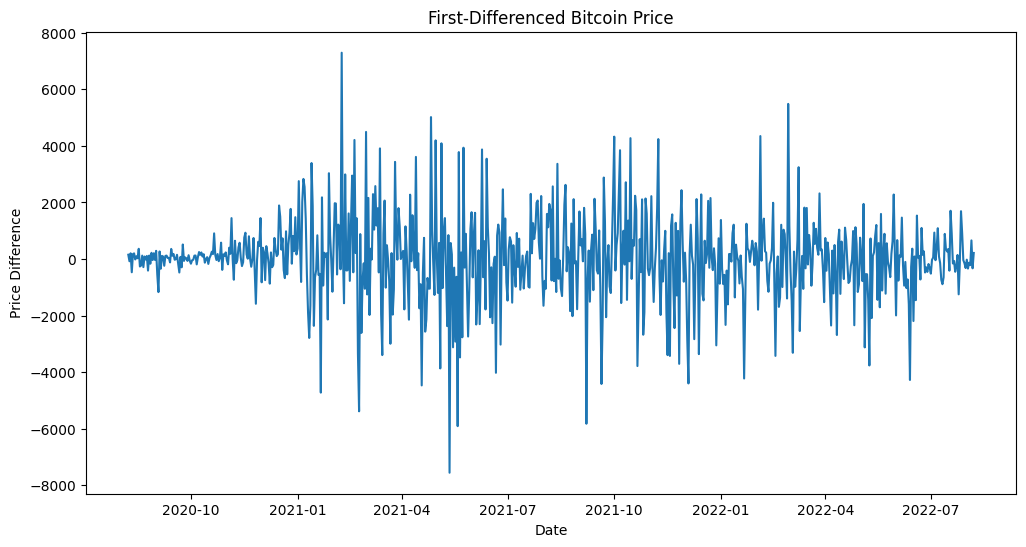

In [5]:
def perform_adf_test(series, series_name):
    """Performs ADF test and prints results."""
    print(f'\n--- Augmented Dickey-Fuller Test Results for {series_name} ---')
    # The dropna() is important if the series was created by differencing
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'  {key}: {value:.4f}')

    if result[1] <= 0.05:
        print(f"Conclusion: Reject the null hypothesis. {series_name} is likely stationary (p-value <= 0.05).")
    else:
        print(f"Conclusion: Fail to reject the null hypothesis. {series_name} is likely non-stationary (p-value > 0.05).")
    return result[1] # Return p-value

# Test original series
p_value_original = perform_adf_test(btc_price['Close_Btc'], 'Original Bitcoin Price')

# If non-stationary, try differencing
if p_value_original > 0.05:
    print("\nOriginal series is non-stationary. Applying first-order differencing.")
    btc_price_diff1 = btc_price['Close_Btc'].diff().dropna() # First difference
    p_value_diff1 = perform_adf_test(btc_price_diff1, 'First-Differenced Bitcoin Price')

    # Plot differenced series
    plt.figure(figsize=(12, 6))
    plt.plot(btc_price_diff1)
    plt.title('First-Differenced Bitcoin Price')
    plt.xlabel('Date')
    plt.ylabel('Price Difference')
    plt.show()

    # If still non-stationary (unlikely for price data after 1 diff), try second differencing
    # if p_value_diff1 > 0.05:
    #     print("\nFirst-differenced series is still non-stationary. Applying second-order differencing.")
    #     btc_price_diff2 = btc_price_diff1.diff().dropna() # Second difference
    #     perform_adf_test(btc_price_diff2, 'Second-Differenced Bitcoin Price')
    #     # Plot second differenced series...

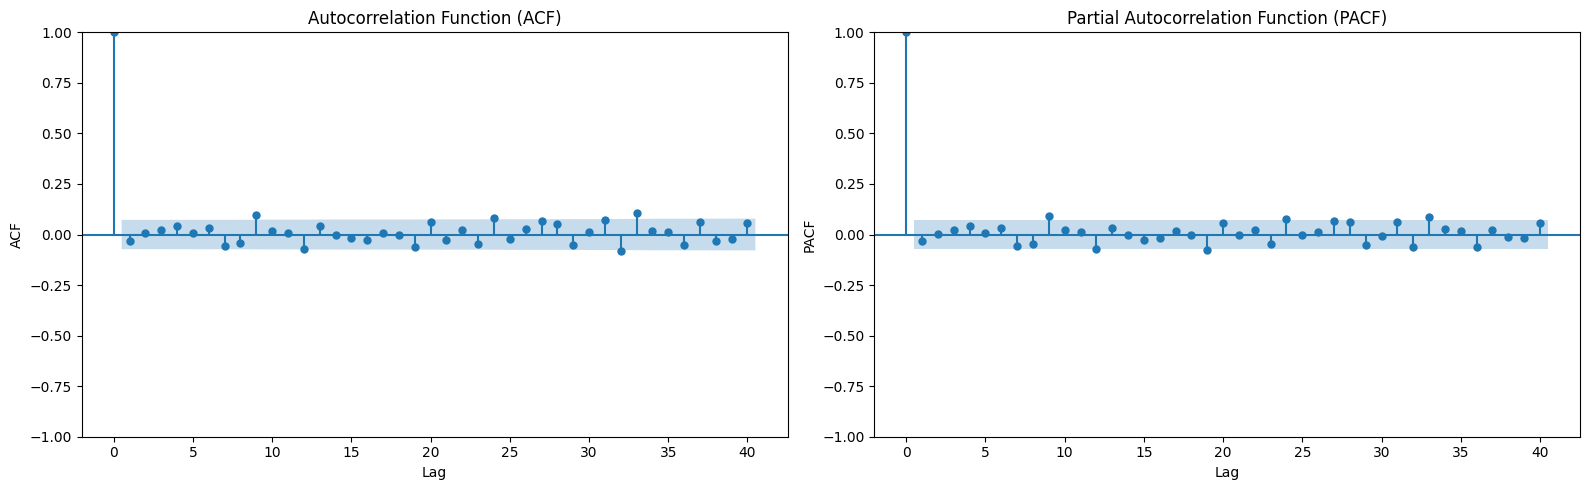

In [6]:
# Assuming first differencing made the series stationary (d=1)
# If the original series was stationary, use btc_price['Close_Btc'] instead of btc_price_diff1
# If second differencing was needed, use btc_price_diff2
stationary_series = btc_price_diff1 # Or whichever series became stationary

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Autocorrelation Function (ACF) plot
plot_acf(stationary_series, ax=ax[0], lags=40, title='Autocorrelation Function (ACF)')
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("ACF")

# Partial Autocorrelation Function (PACF) plot
plot_pacf(stationary_series, ax=ax[1], lags=40, title='Partial Autocorrelation Function (PACF)')
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("PACF")

plt.tight_layout()
plt.show()

# Determine d based on Step 3 (e.g., d=1 if first differencing was used)
d = 1 # Change if needed based on ADF test results